In [19]:
pip install xgboost scikit-learn pandas

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob

# Load your dataset
# Assuming you have a CSV file with columns 'preprocessed_text_tokenized' and 'polarity_label'
# Adjust the file path accordingly
data = pd.read_csv('/content/10Benzema20Neymar26RonaldoUPDATED.csv')

# Apply the sentiment analysis function to the 'preprocessed_text_tokenized' column and create a new 'polarity' column
data['polarity'] = data['preprocessed_text_tokenized'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Assign labels based on polarity
data['polarity_label'] = data['polarity'].apply(lambda x: 1 if x > 0 else 0 if x == 0 else -1)

# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data['preprocessed_text_tokenized'], data['polarity_label'], test_size=0.2, random_state=42
)

# Convert text data to feature vectors using CountVectorizer
vectorizer = CountVectorizer(max_features=5000)  # You can adjust the max_features parameter
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)

# Use LabelEncoder to transform labels into consecutive integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Initialize XGBoost model
xgb_model = XGBClassifier()

# Train the model
xgb_model.fit(train_features, train_labels_encoded)

# Make predictions on the test set
predictions = xgb_model.predict(test_features)

# Evaluate the accuracy
accuracy = accuracy_score(test_labels_encoded, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 90.26%


In [21]:
# Evaluate the accuracy on the training set
train_predictions = xgb_model.predict(train_features)
train_accuracy = accuracy_score(train_labels_encoded, train_predictions)

# Print the scores on training and test set
print(f'Training Set Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Set Accuracy: {accuracy * 100:.2f}%')

Training Set Accuracy: 92.03%
Test Set Accuracy: 90.26%


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Calculate precision, recall, and F1-score on the test set
precision = precision_score(test_labels_encoded, predictions, average='weighted')
recall = recall_score(test_labels_encoded, predictions, average='weighted')
f1 = f1_score(test_labels_encoded, predictions, average='weighted')

print(f'Weighted Precision on Test Set: {precision:.4f}')
print(f'Weighted Recall on Test Set: {recall:.4f}')
print(f'Weighted F1-score on Test Set: {f1:.4f}')




Weighted Precision on Test Set: 0.9084
Weighted Recall on Test Set: 0.9026
Weighted F1-score on Test Set: 0.9016


In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[1360  315  153]
 [  28 3414   26]
 [ 110  354 4363]]


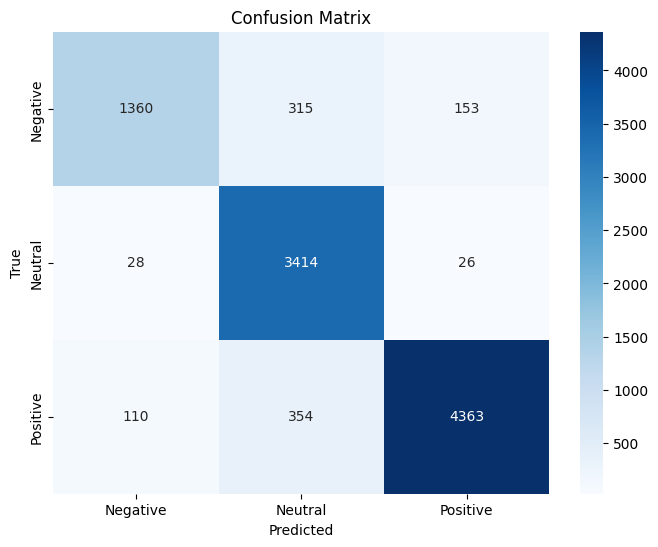

In [24]:

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

AUC Score (Class 0): 0.9650
AUC Score (Class 1): 0.9816
AUC Score (Class 2): 0.9790


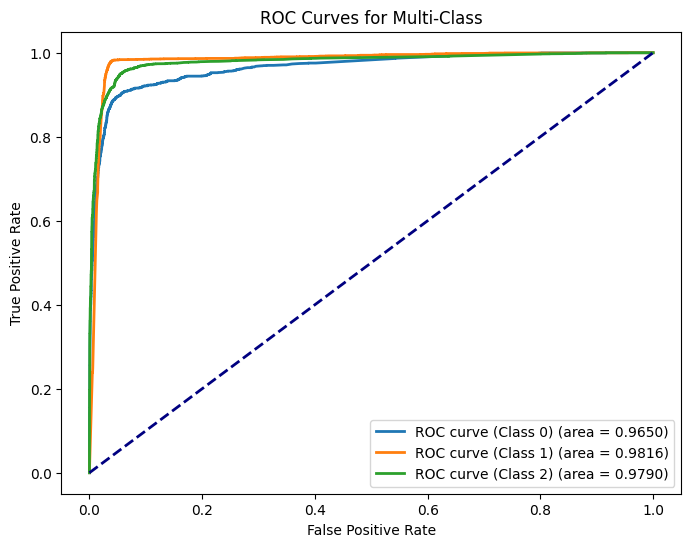

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Binarize the labels for multi-class AUC
test_labels_bin = label_binarize(test_labels_encoded, classes=[0, 1, 2])  # Adjust the classes based on your problem

# Get predicted probabilities for each class on the test set
test_probs = xgb_model.predict_proba(test_features)

# Calculate AUC scores for each class
auc_scores = []
for i in range(test_labels_bin.shape[1]):
    auc_scores.append(roc_auc_score(test_labels_bin[:, i], test_probs[:, i]))

# Print AUC scores for each class
for i, auc_score in enumerate(auc_scores):
    print(f'AUC Score (Class {i}): {auc_score:.4f}')

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(test_labels_bin.shape[1]):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (Class {i}) (area = {auc_scores[i]:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class')
plt.legend(loc='lower right')
plt.show()
